***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)
    * Previous: [5.2 Sampling functions and PSFs](5_2_sampling_functions_and_psfs.ipynb) 
    * Next: [5.4 The Dirty Image and Visibility Weights](5_4_imaging_weights.ipynb)

***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Import section specific modules:

In [3]:
from IPython.display import Image
import track_simulator
import AA_filter

## 5.3 Gridding and Degridding for using the FFT <a id='imaging:sec:gridding'></a>

In the previous section several sampling functions were presented. There the sampling functions were already neatly discretized and displayed as images. Each image was a grid of pixels (all with the same size). Fourier inverting such regularly sampled data is done with a fast Fourier Transform (FFT) algorithm. This is called the "fast" Fourier Transform because it is computationally more efficient that the Direct Fourier Transform (DFT). To give an idea of how fast this algorithm is, if there are $N^2$ pixels in the image, the FFT takes roughly $2N^2\log(N)$ computational operations. In contrast, the complexity of the DFT also depends on the number of visibilities $M$ and takes $N^2M$ steps. Here $M\approx N^2$ and for each pixel we must take $M$ complex exponentiations and multiplications. Specifically, the DFT calculates the intensity of each pixel:

\begin{equation}
 I(l,m) = \sum_{k=0}^{M-1}V_k(u,v)e^{2\pi i (lu+mv)}\text{, }V_k\text{ are the M measurements taken by the telescope}
\end{equation}

From this it should be clear that as the number of baselines or observation time is increased, the FFT approach would be far less time-consuming than the the direct approach. Unfortunately radio interferometers don't take measurements at regular intervals, and thus an FFT cannot be used on the observation data directly. Instead the data has to be *resampled* onto a grid with points spaced at regular intervals before taking the FFT. This resampling process (called *gridding*) and its inverse (called *degridding*) is the topic of this section. The big idea here is that we do gridding and degridding because it enables us to create an image faster than if we did the DFT.

In addition to the issue of resampling when using the FFT transform approach, is the issue of *aliasing*. The FFT assumes that the input signal (here the spatial frequency domain) is periodic in nature. The resultant image constructed by resampling and inverse FFT therefore repeats at regular intervals: sources near the top of the image are aliased back into the image at the bottom for instance. This introduces the necessity to filter the image with a filter that only passes signal that falls within the field of view being reconstructed. Aliasing is an effect of Nyquist sampling ([$\S$ 2.9 &#10142;](../2_Mathematical_Groundwork/2_9_sampling_theory.ipynb)) the visibilities based on the grid size. An example of this form of aliasing will be given later on.

The following points will be discussed in this chapter:
1. Image resolution and pixel size
2. Recap of the $u,v,w=0$ plane sampling
3. Gridding and degridding, along with a discussion on the use anti-aliasing filters
4. Sample code for degridding a model sky, and gridding and inverting visibilities to form a dirty image.

### 5.3.1 Image Resolution and Pixel Size

When generating an image from visibilities, using either a direct or fast Fourier transform, two parameters need to be defined: the resolution of each pixel and the extent of the image either as the number of pixels or as the size of the field of view (depending on the particular imager). An image will be a two-dimensional array of size $N_l \times N_m$ and each pixel will have a resolution of $(\Delta \theta_l, \Delta \theta_m)$ if we are making the small angle approximation for the field of view. Recall that the image size is $l' = \cos{\theta_l}$, $m' = \cos{\theta_m}$, the resolution is $\Delta l = \cos{\Delta \theta_l}$, $\Delta m = \cos{\Delta \theta_m}$ and in the small angle approximation $\Delta l \sim \Delta \theta_l$, $\Delta m \sim \Delta \theta_m$. Though, many imagers can create images which break the small angle approximation the notation is retained. There are a number of techniques for representing a point in spherical coordinates, via a non-linear transform, on a two-dimensional plane. In radio interferometry the standard technique is SIN-projection, see [<cite data-cite='Greisen1994'>AIPS Memo 27</cite> &#10548;](ftp://ftp.aoc.nrao.edu/pub/software/aips/TEXT/PUBL/AIPSMEMO27.PS) for a detailed discussion of different coordinate projections.

Given the the resolution $(\Delta \theta_l, \Delta \theta_m)$ and the desired field of view $(\theta_l, \theta_m)$, the number of pixels in the image (the image size) is

$$N_l = \frac{\theta_l}{\Delta \theta_l}$$

$$N_m = \frac{\theta_m}{\Delta \theta_m}$$

For a given image resolution and image size the uv domain resolution/grid size $(\Delta u, \Delta v)$ is

$$\Delta u = \frac{1}{N_l \Delta \theta_l}$$

$$\Delta v = \frac{1}{N_m \Delta \theta_m}$$

And the number of pixels is unchanged $N_u = N_l$, $N_v = N_m$.

An important note about the number of pixels is that one should try to use values which are powers of 2, i.e. $N_l = 2^j$, $N_m = 2^k, $ for some positive $j,k$. This is because of how FFT's are implemented, the optimal run-time efficiency of an FFT is with input lengths which are powers of 2 and are least efficient when the input length is a prime number. For example, the time required to generate a 256 by 256 pixel ($2^8$ by $2^8$) image will be less than a 251 by 251 pixel image even though the resulting image will have more pixels. Also, note, interferometric images are almost always square by convention.

### 5.3.2 The UV Plane

To start off the discussion on the resampling and image synthesis process let's consider a simulated JVLA observation. The JVLA has 27 reconfigurable antennae. We will use the compact D configuration as shown below:

In [ ]:
#Globals file with JVLA D-configuration antenna ENU coordinates
%run jvla_d_constants.py

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("ENU ANTENNA COORDINATES")
plt.plot(ENU[:,0],ENU[:,1],"r+")
plt.xlabel("E (m)")
plt.ylabel("N (m)")
plt.show()

*Figure: Positions of the 27 antennae of the JVLA (compact D-configuration)*

As discussed in the previous section in order to accurately reconstruct an image it is necessary to measure a significant portion of the spatial frequency domain. Luckily, good coverage on the $u,v$ plane (plane on which the measurements are taken) doesn't require physically moving the antennae while observing. The Fourier relationship between the sky and the measurements taken by an interferometer depends on the orientation of the projected baseline vectors between antennae pairs relative to the sky, and these vectors change as the Earth rotates. As the earth rotates more samples are taken and the tracks swept out by each antenna pair become longer. Since the u,v coordinates are scaled by wavelength the individual tracks can be broadened by increasing ht eobserving bandwidth. Both observation time and the bandwidth contribute to the sampling of the visibility plane. The following plots show how the u,v coverage (swept out by pairs of antennae) depend on declination angle (DEC), as well as the observation length:

In [ ]:
uv_5min = track_simulator.sim_uv(0.0, 90.0, 5/60.0, 60/3600.0, ENU, ARRAY_LATITUDE, True)
uv_6hrs_90_dec = track_simulator.sim_uv(0.0, 90.0, 6, 60/3600.0, ENU, ARRAY_LATITUDE, True)
uv_6hrs_45_dec = track_simulator.sim_uv(0.0, 45.0, 6, 60/3600.0, ENU, ARRAY_LATITUDE, True)
uv_6hrs_20_dec = track_simulator.sim_uv(0.0, 20.0, 6, 60/3600.0, ENU, ARRAY_LATITUDE, True)
uv_6hrs_0_dec = track_simulator.sim_uv(0.0, 0.0, 6, 60/3600.0, ENU, ARRAY_LATITUDE, True)

*Figure: JVLA D-configuration uv coverage at various declinations. The projection of the baselines onto the UV plane at $DEC=90^\circ$ are concentric circles. As the observation declination decreases the projections become straight lines. Here the baselines and their conjugates are plotted. An interferometer measures both the visibility and its complex conjugate simultaniously (baseline and its negative). The conjugate baselines are redundant measurements and can be discarded.*

However, as is evident these samples do not fall at regularly spaced positions. The goal of *gridding* is to "interpolate" these samples onto regularly spaced grid positions. As you will see later some u,v space image deconvolution algorithms such as the [Cotton-Schwab &#10142;](../6_Deconvolution/6_3_clean_flavours.ipynb) major-minor cycle algorithm require that sources in image space are reconverted back into the non-regular measurement space. Here an accurate *degridding* operation is required to "interpolate" regularly sampled visibilities back onto the u,v tracks shown above.

### 5.3.3 Gridding and Degridding

As you may suspect there are many ways to interpolate data to and from regularly-spaced coordinates. The most widely-used interpolation technique used in radio imaging programs, such as `lwimager`, is known as "convolutional-resampling". In this technique each visibility is weighted and "smeared out" onto grid points that lie within a small distance from the original coordinate.

In [ ]:
Image(filename="figures/gridding_illustration.png")

*Figure: Each observed visibility is centered at some sampling coordinate
in continuous u,v space and is weighted with some function $C(u,v)$, which extends only to finite “full support” region as illustrated. The result is either binned in a regularly spaced grid when gridding or gathered from this grid when degridding. After all of the observed visibilities have been gridded an Inverse Fast Fourier Transform is performed to create an image of the sky. The reverse operations are done when simulating a set of visibility measurements from a model sky.*

The value at each grid point, then, is a weighted accumulation of all the nearby visibilties. In one dimension this can be stated as (visually illustrated below):

\begin{equation}
 (\forall a \in \{1,2,\dots,N\}) \mathscr{V}(a\Delta{x}) = \sum_{\substack{
                                                                     i | x_i \geq a\Delta{x}-\text{half support}, \\ 
                                                                     x_i \leq a\Delta{x}+\text{half support}}
                                                                 }{\mathscr{V}(x_i) \, C(a\Delta{x}-x_i)}
\end{equation}

In [ ]:
N = 30
dx = 1
a = np.arange(N)
M = 75
tap_pos = (N//2)*dx
conv_hsup = 5*dx
conv_x = np.linspace(-conv_hsup,conv_hsup,1000)
vis_x = np.sort(np.random.rand(M)*N*dx)
vis = 1.5+np.random.rand(M)*0.7 + 0.3
plt.figure(figsize=(13,5))
ax1 = plt.axes()
ax1.axes.get_yaxis().set_visible(False)
for x in a*dx:
    plt.plot([x,x],[-1.5,-1.0],'k')
plt.plot(vis_x,vis,'b.')
plt.plot(vis_x,np.ones([M])*-1.25,'g.')
plt.plot([vis_x[0],vis_x[0]],[-1.25,vis[0]],'b--')
plt.plot(tap_pos+conv_x,np.sinc(conv_x),'r')

plt.arrow(tap_pos-conv_hsup, -0.25, 0, 2.5+0.5, head_width=0.0, head_length=0.0, fc='m', ec='m')
plt.arrow(tap_pos+conv_hsup, -0.25, 0, 2.5+0.5, head_width=0.0, head_length=0.0, fc='m', ec='m')
plt.arrow(tap_pos-conv_hsup, -0.25, conv_hsup*2, 0, head_width=0.0, head_length=0.0, fc='m', ec='m')
plt.arrow(tap_pos-conv_hsup, 2.5+0.25, conv_hsup*2, 0, head_width=0.0, head_length=0.0, fc='m', ec='m')

plt.text(tap_pos+0.75, -0.70, "$\sum{\mathscr{V}(x_i)C(a\Delta{x}-x_i)}$", fontsize=11,color='m')
plt.text(tap_pos+conv_hsup+0.15, 0, "$C$", fontsize=13,color='r')
plt.text(0.5, 2.5, "$\mathscr{V}(x_i),x_i\in\mathbb{R}$", fontsize=16,color='b')
plt.arrow(tap_pos, -0.25, 0, -0.45, head_width=0.75, head_length=0.3, fc='m', ec='m')
plt.ylim(-1.75,3.0)
plt.xlim(-0.5*dx,N*dx)
plt.xlabel("Grid position ($a\Delta{x}$)",fontsize=15)
plt.show()

*Figure: Here we have illustrated the gridding process in one dimension. Given a continuous visibility function sampled at some, non-regular, points in $x$ and a convolution function, $C$, the points stored at regular intervals (black bars) is approximately a convolution between the visibility function and the convolution function. The coordinates the visibility function is sampled at, is plotted with green dots in-between the regularly sampled grid positions.*

The weighting function, $C$ can be any number of functions proposed in the literature. These include linear, Lagrange, sinc (including one of the many window functions), Gaussian, modified B-spline, etc. 

You may have noticed that the interpolating function above is remarkably close to that of a discrete convolution. If the resampling was done on data that was regularly sampled and the convolution function evaluated at these regular discrete steps then the function would just the ordinary discrete convolution. However, the function as it stands is not quite a convolution by the strictest definition of the word. Gridding and degridding should be thought of as approximations to the discrete convolution. Nevertheless we will use the regular convolution notation in our discussion.

For those coming from a signal processing background it is useful to think of the convolutional gridding and degridding operations in terms of the ordinary upsampling and downsampling operations. In gridding, as with traditional upsampling, the space in-between samples are filled with zero values. The only difference is that with gridding the original measurements are not regularly-spaced, as would be the case with upsampling. Just as with upsampling it is then necessary to assign values to these new zero values in-between the measured values. With gridding the values are smeared out over the grid points within a some area of support.

This is a very important point. During the gridding process, because the uv plane is not fully sampled, many of the grid points are assigned a value fo zero! Now, there is essantially no chance that a gridded visibility value is actually zero, but since we have not sampled that point in the visibility domain the only option is to assign that pixel some value. Zero is convenient, but not the true value. We will come back to this point in the next chapter on [deconvolution &#10142;](6_Deconvolution/6_0_introduction.ipynb) which requires us to include additional knowledge to make an informed guess about what the value of these pixels could be. 

With this understanding in hand we can define gridding and degridding more rigorously:

\begin{equation}
 \begin{split}
     V_\text{gridded}[u,v]&=[(\mathscr{V}(u,v) \, S(u,v))\circ C(u,v)] \, III[u,v]\\
     V_\text{degridded}(u,v)&=[V_\text{gridded}[u,v]\circ C(u,v)] \, S(u,v)\\
 \end{split}
\end{equation}

In gridding the sampled visibilities are convolved with a convolution function then discretized onto regular points by the shah (bed-of-nails) function ([$\S$ 2.2 &#10142;](../2_Mathematical_Groundwork/2_2_important_functions.ipynb)). In degridding the opposite is done: the regularly sampled discerete values are convolved and sampled along the sampling tracks in the u,v plane. The convolution function smears (gridding) and gathers (degridding) the visibilities over / from some area of support before discretizing the visibilities to new coordinates. Ideally this function would be computed during the gridding and degridding operations, however, considering that the processing costs of gridding and degridding both scale as $MC_\text{sup}^2$ these functions can be too computationally expensive to compute for every visibility and is normally pretabulated for a given support size. Additionally it is important to sample this function much more densely than the spacings between grid cells; interferometers take measurements in the spatial frequency domain and any large snapping / rounding operation on the coordinates of the samples will result in a decorrelation in the structural information about the image. The figure below illustrates how values are picked from the oversampled filter.

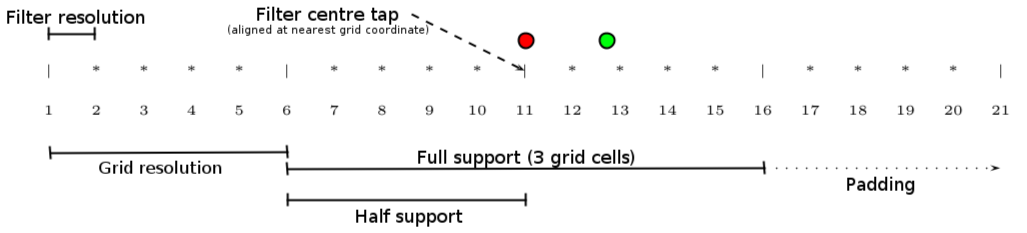

In [5]:
Image(filename="figures/oversampled_filter_illustration.png")

*Figure: Here the indexing for a padded, oversampled filter is illustrated for a 3-cell full-support region (half support of 1 to both sides of the centre value), padded with one value on both sides. The filter is 5x oversampled, as indicated by the spaces between the asterisks. The bars represent the grid resolution ($\Delta{u}$ or $\Delta{v}$). If the measured uv coordinate falls exactly on the nearest grid cell (red dot) then values 6,11 and 16 are selected as interpolation coefficients. If the uv value is slightly offset, for instance $\text{round}(\text{fraction}(u, v)m_\text{oversample factor})$ = 2 (green dot), then 8, 13 and 18 are selected for the 3 interpolation coefficients. In other words: a denser bed of nails is placed over the bed of nails of the grid and the closest set of coefficients for the convolution are selected.*

More importantly, the alias-reduction properties of the convolution filter being used are essential to the FFT approach. By the convolution theorem the reconstructed image of the radio sky can be stated as follows:

\begin{equation}
I_\text{dirty}[l,m] = ([I(l,m)\circ\text{PSF}(l,m)] \, c(l,m))\circ\mathscr{F}\{III\}[l,m]
\end{equation}

The Fourier transform of the shah function $\mathscr{F}\{III\}[l,m]$ is a series of periodic functions in the image domain. Convolution with these periodic functions replicates the field of view at a period of $M\Delta{\theta_l}$ and $N\Delta{\theta_m}$ for an $M\times N$ pixel image, and it is this aliasing effect that must be stopped. To that end one would hope that the Fourier transform of the convolution filter, $c(l,m)$, maximizes the following ratio:

\begin{equation}
\frac{\int_\text{FOV} \lvert c(l,m) \rvert^2dS}{\int_{-\infty}^\infty \lvert c(l,m) \rvert^2dS}
\end{equation}

Simply stated, it is desirable that the function $c$ is only non-zero over a small central region: the field of view.

Both the remarks about accuracy and anti-aliasing properties of the filter precludes using a nearest-neighbour approach to interpolating points to and from regular coordinates. Interpolation accuracy takes presidence in degridding, while alias-reduction is important for gridding. Nearest-neighbour interpolation (also known as *cell-summing* in older literature) simply accumulates the neighbouring points that fall within a rectangular region around the new coordinate, without considering the distance those points are from the new coordinate. The Fourier transform of this box function is an infinite sinc function, which ripples out slowly towards infinity, and doesn't stop much of the aliasing effect. Convolutional gridding/degridding is therefore a more attractive approach, because the distance between the grid point and the measured uv point is taken into account when selecting a set of convolution weights.

The observation about the Fourier transform of the box function leads us to a partial solution for the aliasing problem, in that convolving with an *infinite* sinc will yield an image tapered by a box function. Unfortunately this is not computationally feasible and instead the best option is to convolve with either a truncated sinc function, or some other function that has a similar centre-heavy Fourier transform and preferably tapers off reasonably quickly. The images below illustrates the significant improvement using a truncated sinc function instead of nearest-neighbour interpolation.

In [ ]:
Image(filename="figures/NN_interpolation_aliasing.png", width=512)

In [ ]:
Image(filename="figures/AA_kernel_alias_reduction.png", width=512)

*Figure: Above two synthesized images of a grid of point sources. The first using cell-summing (nearest neighbour) interpolation and the second using convolutional resampling with a simple truncated sinc function. In the first the sources of this grid sky pattern that fall slightly outside the field of view are aliased back into the field of view. In the second the aliasing energy is limited by the box response of the sinc function.*

Below the magnitude of the sidelobes of the Fourier transforms of several functions are plotted. The sidelobes of the Fourier transform of the box function is significantly higher than that of truncated and windowed sinc functions.

In [ ]:
half_sup = 6
oversample = 15
full_sup_wo_padding = (half_sup * 2 + 1)
full_sup = full_sup_wo_padding + 2 #+ padding
no_taps = full_sup + (full_sup - 1) * (oversample - 1)
taps = np.arange(-no_taps//2,no_taps//2 + 1)/float(oversample)

#unit box
box = np.where((taps >= -0.5) & (taps <= 0.5),
               np.ones([len(taps)]),np.zeros([len(taps)]))
fft_box = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(box))))
#truncated (boxed) sinc
sinc = np.sinc(taps)
fft_sinc = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinc))))
#gaussian sinc
alpha_1 = 1.55
alpha_2 = 2.52
gsinc = np.sin(np.pi/alpha_1*(taps+0.00000000001))/(np.pi*(taps+0.00000000001))*np.exp(-(taps/alpha_2)**2)
fft_gsinc = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(gsinc))))
#plot it up
plt.figure(figsize=(7, 5), dpi=80)
l = np.arange(-(no_taps)//2,(no_taps)//2+1) * (1.0/oversample)
a, = plt.plot(2*l, 10.*np.log10(fft_box))
b, = plt.plot(2*l, 10.*np.log10(fft_sinc))
c, = plt.plot(2*l, 10.*np.log10(fft_gsinc))
ax = plt.gca()
ax.set_xlim(0,no_taps//2 * (1.0/oversample))
#ax.set_yscale("log", nonposy='clip')
plt.legend([a,b,c],["Box","Sinc","Gaussian Sinc"])
plt.xlabel("$2\Delta{u}l$")
plt.ylabel("Magnitude of $c(l)$ (dB)")
plt.title("Magnitude of Fourier transforms of several convolution functions")
plt.show()

*Figure: The magnitudes of the Fourier transforms of various functions. It is desirable that most of the energy of these functions fall within some central region and that the response drops off sharply at the edge of this central region*

After Fourier transformation the effects of the convolution function on the image can be mitigated by point-wise dividing the image through by the Fourier transform of the convolution function, $c(l,m)$. This has the effect of flattening the response of the passband, by removing the tapering towards the edges of the image, but raises the amplitude of any aliased sources at the edge of the image.

In practice the proloid spheroidal functions are used in imaging programs such as `lwimager`, but the definition of these functions are beyond the scope of the introductory discussion here and the reader is referred to the work of Donald Rhodes, [<cite data-cite='rhodes1970spheroidal'>On the Spheroidal Functions</cite> &#10548;](http://cdm16009.contentdm.oclc.org/cdm/compoundobject/collection/p13011coll6/id/61576/rec/50) for a detailed discussion of their definition and proof of their aliasing reduction properties.

It is also worth noting that the convolution functions used in gridding and degridding need not be the same function. In degridding the focus is solidly on the accuracy of the predicted visibility. Here it can be advantageous to minimize the difference between a direct transformation approach and a Fast Fourier Transform approach with degridding, see for instance the discussion by Sze Tan, [<cite data-cite='tan1986aperture'>Aperture-synthesis mapping and parameter estimation</cite> &#10548;](http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.ethos.384529) for further detail. 

### 5.3.4 Example Simulator and Imager

We conclude this section with some sample code to illustrate prediction and imaging using resampling and the FFT. To start off let's set up a model sky with 50 random sources with a maximum brightness of 5Jy. Then we simulate the measurement space by taking the fourier transform of this model sky:

In [ ]:
model_sky = np.zeros([256,256])
for i in range(50):
    model_sky[int(np.random.rand()*255),int(np.random.rand()*255)] = np.random.rand()*5.0 

model_regular = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(model_sky))) #numpy's FFT doesn't need normalization
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title("Model sky")
plt.imshow(model_sky,cmap="gray")
plt.xlabel("l")
plt.ylabel("m")
plt.subplot(132)
plt.title("Amplitudes of visibilliy space")
plt.imshow(10*np.log10(np.abs(model_regular+0.000000000001)))
plt.xlabel("u")
plt.ylabel("v")
plt.subplot(133)
plt.title("Phase of visibility space")
plt.imshow(np.angle(model_regular))
plt.xlabel("u")
plt.ylabel("v")
plt.show()

*Figure: The simulated model sky (l,m space) and its fourier transform in the visibility space (u,v space)*

Next we set up a sampling pattern and scale the u,v tracks to ensure that they all fall within the u,v grid:

In [ ]:
#Set up interferometer sampling pattern
uvw = track_simulator.sim_uv(0.0,90.0,1.5,60/3600.0,ENU,ARRAY_LATITUDE)
#Then scale the u,v coordinates such that the uv coverage falls entirely on the uv grid
#Note: this scales the effective FOV by the similarity theorem
max_u = np.max(np.abs(uvw[:,0]))
max_v = np.max(np.abs(uvw[:,1]))
print "Maximum u,v: (%f,%f)" % (max_u,max_v)
#N * cell_size_in_rads = 2 * max_uv
#therefore cell_size_in_rads = 2 * max_uv / N
Nx = model_sky.shape[0]
Ny = model_sky.shape[1]
cell_size_u = 2 * max_u / (Nx)
cell_size_v =  2 * max_v / (Ny)
print "Nyquest cell size (radians) in image space (%f,%f)" % (cell_size_u,cell_size_v)
scaled_uv = np.copy(uvw[:,0:2])
scaled_uv[:,0] /= cell_size_u
scaled_uv[:,1] /= cell_size_v
scaled_uv[:,0] += Nx/2
scaled_uv[:,1] += Ny/2
print np.max(scaled_uv[:,0]),np.max(scaled_uv[:,1])
plt.figure(figsize=(10, 10))
plt.title("Sampling of the visibility space (amplitude)")
plt.imshow(10*np.log10(0.00000000001+np.abs(model_regular)))
plt.plot(scaled_uv[:,0],scaled_uv[:,1],"k.",label="Baselines")
plt.colorbar()

*Figure: UV tracks (black) scaled onto the regularly sampled visibility space*

To complete the prediction (also known as the "forward" step) the measurements are resampled onto the u,v tracks of the interferometer using the *degridding* algorithm discussed above. Measurements are gathered and weighted from the vacinity of each of the points along the sampling track in order to "predict" a value at the u,v coordinate.

In [ ]:
# %load convolutional_degridder.py

def fft_degrid(model_image,scaled_uv,Nx,Ny,convolution_filter):
    """
    Convolutional degridder
    
    Keyword arguments:
    model_image --- model image of the sky to degrid onto non-regular uv coordinates
    scaled_uv --- interferometer's uv coordinates. (Prerequisite: these uv points are already scaled by
                  the simularity theorem, such that -N_x*Cell_l*0.5 <= theta_l <= N_x*Cell_l*0.5 and
                  -N_y*Cell_m*0.5 <= theta_m <= N_y*Cell_m*0.5
    Nx,Ny --- size of image in pixels
    convolution_filter --- pre-instantiated AA_filter anti-aliasing filter object
    """
    model_vis_regular = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(model_image)))
    vis = np.zeros([scaled_uv.shape[0]],dtype=np.complex)
    for r in range(0,scaled_uv.shape[0]):
        disc_u = int(round(scaled_uv[r,0]))
        disc_v = int(round(scaled_uv[r,1]))
        frac_u_offset = int((1 - scaled_uv[r,0] + disc_u) * convolution_filter.oversample)
        frac_v_offset = int((1 - scaled_uv[r,1] + disc_v) * convolution_filter.oversample)
        if (disc_v + convolution_filter.full_sup_wo_padding  >= Ny or 
            disc_u + convolution_filter.full_sup_wo_padding >= Nx or
            disc_v < 0 or disc_u < 0): 
            continue
        interpolated_value = 0.0 + 0.0j
        for conv_v in range(0,convolution_filter.full_sup_wo_padding):
            v_tap = convolution_filter.filter_taps[conv_v * convolution_filter.oversample + frac_v_offset]  
            for conv_u in range(0,convolution_filter.full_sup_wo_padding):
                u_tap = convolution_filter.filter_taps[conv_u * convolution_filter.oversample + frac_u_offset]
                conv_weight = v_tap * u_tap
                interpolated_value += model_regular[disc_u - half_sup + conv_u, disc_v - half_sup + conv_v] * \
                conv_weight
        vis[r] = interpolated_value
    return vis

In [ ]:
tabulated_filter = AA_filter.AA_filter(3,30,"sinc")
vis = fft_degrid(model_sky,scaled_uv,Nx,Ny,tabulated_filter)

Next comes a simplified imaging step using the FFT and gridding. The visibilities on the irregularly-spaced u,v tracks are resampled onto regular coordinates. This is done by weighting and smearing each measured visibility out onto the regular coordinates in the vacinity of its u,v coordinate. After resampling the inverse FFT is used to transform the measurements in the spatial frequency domain to those in the spacial domain, thereby approximately reconstructing the model sky we started with.

In [ ]:
# %load convolutional_gridder.py

def grid_ifft(vis,scaled_uv,Nx,Ny,convolution_filter):
    """
    Convolutional gridder
    
    Keyword arguments:
    vis --- Visibilities as sampled by the interferometer
    scaled_uv --- interferometer's uv coordinates. (Prerequisite: these uv points are already scaled
                  by the simularity theorem, such that -N_x*Cell_l*0.5 <= theta_l <= N_x*Cell_l*0.5 and
                  -N_y*Cell_m*0.5 <= theta_m <= N_y*Cell_m*0.5
    Nx,Ny --- size of image in pixels
    convolution_filter --- pre-instantiated AA_filter anti-aliasing filter object
    """
    measurement_regular = np.zeros([Nx,Ny],dtype=np.complex) #one grid for the resampled visibilities
    #for deconvolution the PSF should be 2x size of the image (see Hogbom CLEAN for details)
    sampling_regular = np.zeros([2*Nx,2*Ny],dtype=np.complex) #one grid for the resampled sampling function
    for r in range(0,scaled_uv.shape[0]):
        disc_u = int(round(scaled_uv[r,0]))
        disc_v = int(round(scaled_uv[r,1]))
        frac_u_offset = int((1 - scaled_uv[r,0] + disc_u) * convolution_filter.oversample)
        frac_v_offset = int((1 - scaled_uv[r,1] + disc_v) * convolution_filter.oversample)
        if (disc_v + convolution_filter.full_sup_wo_padding  >= Ny or 
            disc_u + convolution_filter.full_sup_wo_padding >= Nx or
            disc_v < 0 or disc_u < 0): 
            continue
        for conv_v in range(0,convolution_filter.full_sup_wo_padding):
            v_tap = convolution_filter.filter_taps[conv_v * convolution_filter.oversample + frac_v_offset]  
            for conv_u in range(0,convolution_filter.full_sup_wo_padding):
                u_tap = convolution_filter.filter_taps[conv_u * convolution_filter.oversample + frac_u_offset]
                conv_weight = v_tap * u_tap
                measurement_regular[disc_u - convolution_filter.half_sup + conv_u, disc_v - \
                                    convolution_filter.half_sup + conv_v] += vis[r] * conv_weight
                sampling_regular[disc_u - convolution_filter.half_sup + conv_u, disc_v - \
                                 convolution_filter.half_sup + conv_v] += (1+0.0j) * conv_weight
    dirty_sky = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(measurement_regular)))
    psf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sampling_regular)))
    dirty_sky /= np.max(psf) # normalize by the centre value of the PSF
    return dirty_sky, psf

In [ ]:
tabulated_filter = AA_filter.AA_filter(3,63,"sinc")
dirty_sky, psf = grid_ifft(vis,scaled_uv,Nx,Ny,tabulated_filter)

In [ ]:
#plot it up :-)
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title("Model sky")
plt.imshow(model_sky,cmap="gray")
plt.xlabel("l")
plt.ylabel("m")
plt.subplot(132)
plt.title("PSF")
plt.imshow(np.abs(psf),cmap="gray")
plt.xlabel("l")
plt.ylabel("m")
plt.subplot(133)
plt.title("Dirty map")
plt.imshow(np.abs(dirty_sky),cmap="gray")
plt.xlabel("l")
plt.ylabel("m")
plt.show()

*Figure: Reconstructed image of the model sky. This "dirty" image is convolved with the the PSF shown in the centre figure. Some of the fainter sources are hardly visible because of the sidelobes introduced by this convolution.*

Of course this reconstruction can only ever be approximate, since the u,v plane is only partially sampled. The brightest sources are still visible, provided the observation time is long enough. Each of the sources are convolved with the PSF shown above in the centre figure; the ring-like structure of the PSF is clearly visible around the bright sources and can, in the worst case, obscure some of the fainter sources in the image. The deconvolution strategies discussed later attempt to remove the psf structure from the images and improve the fidelity of the reconstructed images.

***

* Next: [5.4 The Dirty Image and Visibility Weights](5_4_imaging_weights.ipynb)